## Import library

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

## Import dataset

In [2]:
df = pd.read_csv("data/income_evaluation.csv")
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age                32561 non-null int64
 workclass         32561 non-null object
 fnlwgt            32561 non-null int64
 education         32561 non-null object
 education-num     32561 non-null int64
 marital-status    32561 non-null object
 occupation        32561 non-null object
 relationship      32561 non-null object
 race              32561 non-null object
 sex               32561 non-null object
 capital-gain      32561 non-null int64
 capital-loss      32561 non-null int64
 hours-per-week    32561 non-null int64
 native-country    32561 non-null object
 income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


,missing_value,%
age,0,0.0
workclass,0,0.0
fnlwgt,0,0.0
education,0,0.0
education-num,0,0.0
marital-status,0,0.0
occupation,0,0.0
relationship,0,0.0
race,0,0.0
sex,0,0.0


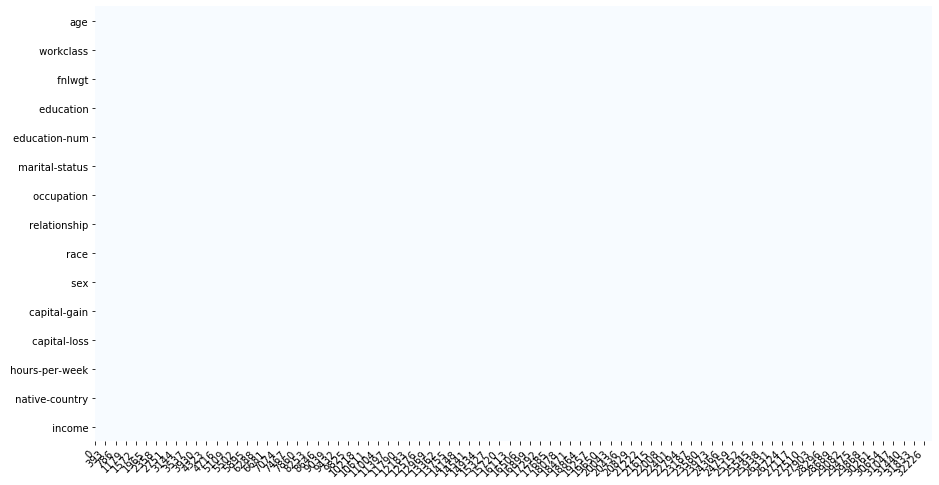

In [4]:
# cek apakah terdapat missing value
plot_missing_value(df, return_df=True)

In [5]:
df[" capital-loss"].value_counts()

0       31042
1902      202
1977      168
1887      159
1848       51
        ...  
1411        1
1539        1
2472        1
1944        1
2201        1
Name:  capital-loss, Length: 92, dtype: int64

In [19]:
df = pd.read_csv("data/income_evaluation.csv", na_values=" ?")

In [20]:
df.isna().sum()

age                   0
 workclass         1836
 fnlwgt               0
 education            0
 education-num        0
 marital-status       0
 occupation        1843
 relationship         0
 race                 0
 sex                  0
 capital-gain         0
 capital-loss         0
 hours-per-week       0
 native-country     583
 income               0
dtype: int64

In [32]:
# melihat data duplikat
df.duplicated().sum()

24

In [33]:
# menghapus data duplikat
df.drop_duplicates(inplace=True)

In [43]:
df[' income'].value_counts()

 <=50K    24698
 >50K      7839
Name:  income, dtype: int64

### Melihat korelasi antara features dengan target

In [21]:
from jcopml.plot import plot_association_matrix

In [22]:
plot_association_matrix(df, ' income', categoric_col='auto')

interactive(children=(ToggleButtons(description='method', options=("Cramer's V", 'Proficiency U(X|Y)', 'Profic…

## splitting dataset

In [24]:
X = df[[' education', ' marital-status', ' occupation', ' relationship']]
y = df[" income"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26048, 4), (6513, 4), (26048,), (6513,))

## Training

### Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [27]:
rsp.rf_params

{'algo__n_estimators': Integer(low=100, high=200),
 'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

In [28]:
X_train.head()

,education,marital-status,occupation,relationship
15738,Bachelors,Married-civ-spouse,Exec-managerial,Husband
27985,Masters,Never-married,Exec-managerial,Not-in-family
30673,HS-grad,Never-married,NaN,Not-in-family
9505,Some-college,Divorced,Transport-moving,Unmarried
26417,Bachelors,Never-married,Prof-specialty,Own-child


In [30]:
preprocessor = ColumnTransformer([
    ('categoric', cat_pipe(encoder='onehot'), [" education", " marital-status", " occupation", " relationship"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.1min finished


{'algo__max_depth': 43, 'algo__max_features': 0.11267184044357602, 'algo__min_samples_leaf': 19, 'algo__n_estimators': 180}
0.8263590294840295 0.8250920648554626 0.8257331490864425


### SVM

In [37]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [39]:
gsp.svm_params

{'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [40]:
preprocessor = ColumnTransformer([
    ('categoric', cat_pipe(encoder='onehot'), [" education", " marital-status", " occupation", " relationship"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:  2.7min finished
D:\MiniConda\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 0.001, 'algo__gamma': 100.0}
0.7775644963144963 0.7900797222578833 0.7785966528481498


### XGboost

In [41]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [42]:
rsp.xgb_params

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [44]:
preprocessor = ColumnTransformer([
    ('categoric', cat_pipe(encoder='onehot'), [" education", " marital-status", " occupation", " relationship"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.6min finished


{'algo__colsample_bytree': 0.3729389632059006, 'algo__gamma': 5, 'algo__learning_rate': 0.11078641782934492, 'algo__max_depth': 5, 'algo__n_estimators': 159, 'algo__reg_alpha': 0.007299348683062313, 'algo__reg_lambda': 0.3101429427212744, 'algo__subsample': 0.342673732496884}
0.8264742014742015 0.8272035366091771 0.8277291570704745
